In [1]:
from river import drift
from drift_runner.utils import get_paths
from stream_generator import FeatureImportanceChangeGenerator
from drift_runner.drift_runner import DriftDetectionRunner
from drift_runner.utils import plot_all_strategies
import warnings
warnings.filterwarnings('ignore')


## loop

In [2]:
drift_detectors = {
    'adwin': [drift.ADWIN(delta=0.002), drift.ADWIN(delta=0.02)],
    'kswin': [drift.KSWIN(alpha=0.005),  drift.KSWIN(alpha=0.05)]
}


strategies = ['all_features_no_reset', 'all_features_with_reset', 'boruta_initial_only', 'boruta_dynamic', 'alpha_dynamic', 'oracle']
feature_selectors = ['boruta', 'alpha']
models = ['hoeffding', 'no_change', 'majority_class']
n_windows = [10, 50, 100]
model = 'hoeffding'

In [3]:
# generator 
seed = 160
n_features = 20
n_important_features = 5
importance_change_interval = 10

In [4]:
# for detector_name, detectors in drift_detectors.items():
#     main_detector, sensitive_detector = detectors
#     for strategy in strategies:
#         feature_selector = strategy.split('_')[0]
#         feature_selector = feature_selector if feature_selector in ['boruta', 'alpha'] else None
#         if strategy in ['boruta_initial_only', 'boruta_dynamic', 'alpha_dynamic']:
#             for window in n_windows:
#                 plot_path, export_path = get_paths(detector_name, seed, window, strategy)
                
#                 generator = FeatureImportanceChangeGenerator(n_features=n_features, n_important_features=n_important_features, importance_change_interval=importance_change_interval, random_seed=seed)
#                 runner = DriftDetectionRunner(generator,drift_detector=main_detector, sensitive_drift_detector=sensitive_detector, feature_selector=feature_selector, model_type=model, plot_path=plot_path, export_path=export_path, print_plot=False)
#                 runner.run(mode=strategy)
#         else:
#             plot_path, export_path = get_paths(detector_name, seed, None, strategy)
            
#             generator = FeatureImportanceChangeGenerator(n_features=n_features, n_important_features=n_important_features, importance_change_interval=importance_change_interval, random_seed=seed)
#             runner = DriftDetectionRunner(generator, drift_detector=main_detector, sensitive_drift_detector=sensitive_detector, feature_selector=feature_selector, model_type=model, plot_path=plot_path, export_path=export_path, print_plot=False)
#             runner.run(mode=strategy)
                

## single

[Oracle] Drift at epoch 1 → resetting model and applying oracle features
Epoch 0, Accuracy: 0.00%
[Oracle] Drift at epoch 913 → resetting model and applying oracle features
Epoch 1000, Accuracy: 87.79%
[Oracle] Drift at epoch 1943 → resetting model and applying oracle features
Epoch 2000, Accuracy: 88.39%
[Oracle] Drift at epoch 2753 → resetting model and applying oracle features
Epoch 3000, Accuracy: 89.69%
Epoch 4000, Accuracy: 90.67%
[Oracle] Drift at epoch 4257 → resetting model and applying oracle features
Epoch 5000, Accuracy: 90.71%
[Oracle] Drift at epoch 5258 → resetting model and applying oracle features
Epoch 6000, Accuracy: 90.96%
[Oracle] Drift at epoch 6302 → resetting model and applying oracle features
Epoch 7000, Accuracy: 90.68%
[Oracle] Drift at epoch 7399 → resetting model and applying oracle features
Epoch 8000, Accuracy: 90.63%
[Oracle] Drift at epoch 8314 → resetting model and applying oracle features
Epoch 9000, Accuracy: 90.71%
[Oracle] Drift at epoch 9323 → res

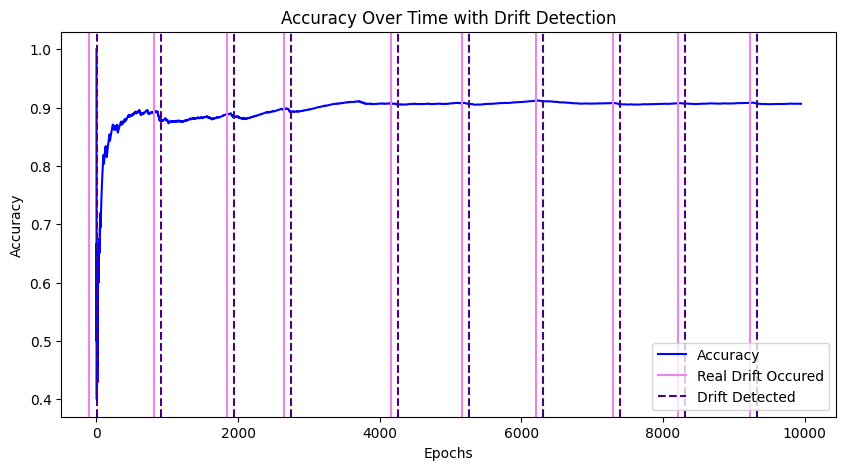

Run data exported to ./logs/None/160_seed/oracle.json


In [5]:
strategy = 'oracle'
seed = 160
feature_selector = None
chosen_detector = None
model_type = 'hoeffding' # 'hoeffding', 'no_change', 'majority'

generator = FeatureImportanceChangeGenerator(n_features=20, n_important_features=5, importance_change_interval=10, random_seed=seed)

plot_path, export_path = get_paths(chosen_detector=chosen_detector, seed=seed, window=50, strategy=strategy)

# main_detector = drift.ADWIN(delta=0.002)
# sensitive_detector = drift.ADWIN(delta=0.02)

main_detector = drift.KSWIN(alpha=0.005)
sensitive_detector = drift.KSWIN(alpha=0.05)

runner = DriftDetectionRunner(
    generator=generator,
    drift_detector=None,
    sensitive_drift_detector=None,
    model_type=model_type,
    feature_selector=feature_selector,
    plot_path=plot_path,
    export_path=export_path,
    print_plot=True,
    window_size=50
    
)
runner.run(mode=strategy)

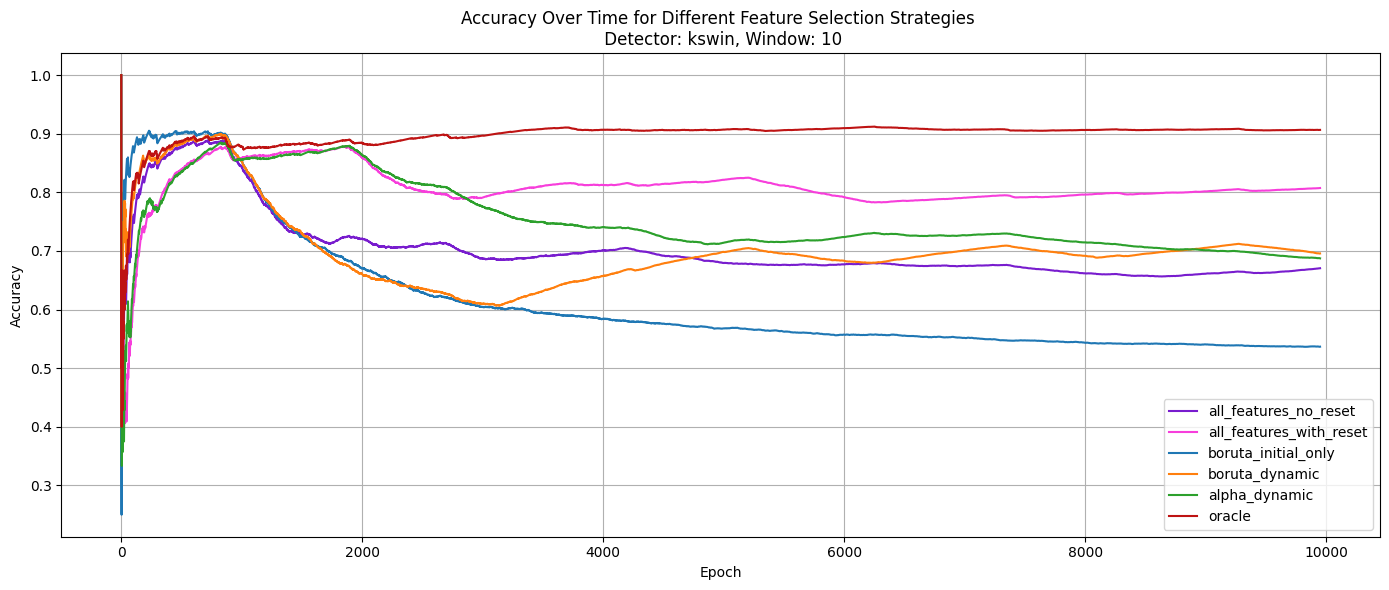

In [11]:
strategies = [
    'all_features_no_reset',
    'all_features_with_reset',
    'boruta_initial_only',
    'boruta_dynamic',
    'alpha_dynamic',
    'oracle',
]



detector = 'kswin'
seed = 160
window = 10


plot_all_strategies(detector, seed, window, strategies)